<a href="https://colab.research.google.com/github/NicolePereira19/DATA4auditors_IAEMetz/blob/main/Analyse_des_actions_Amazon%2C_Netflix_%26_Disney.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse des actions Netflix, Amazon et Disney
### Le but de cette analyse est à la fin de pourvoir constater quelle action est la plus performante et dans laquelle nous recommendions y investir

## Importation des bibliothèques

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import norm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy.cluster.hierarchy import dendrogram, linkage

## Chargement des fichiers CSV avec les données des actions et du S&P500

In [ ]:
netflix_data = pd.read_csv('/content/Netflix.csv', index_col='Date', parse_dates=True)
amazon_data = pd.read_csv('/content/Amazon.csv', index_col='Date', parse_dates=True)
disney_data = pd.read_csv('/content/Disney.csv', index_col='Date', parse_dates=True)
sp500_data = pd.read_csv('/content/SP500.csv', index_col='Date', parse_dates=True)
all_stocks = pd.concat([netflix_data, amazon_data, disney_data, sp500_data], axis=1)
all_stocks.columns = ['Netflix', 'Amazon', 'Disney', 'S&P 500']
all_stocks.head()

,Netflix,Amazon,Disney,S&P 500
Date,,,,
2010-03-04,NaN,NaN,NaN,1122.973560
2010-03-05,9.664276,6.445500,33.22,1138.698076
2010-03-08,9.811419,6.505500,33.19,1138.504873
2010-03-09,9.991419,6.441001,33.31,1140.446408
2010-03-10,10.182847,6.525500,33.33,1145.608972


In [ ]:
# Identifier le bon nom de colonne pour le prix de clôture
close_column = 'Adj Close' if 'Adj Close' in netflix_data.columns else netflix_data.columns[-1]

# S'assurer que l'index est bien trié
netflix_data = netflix_data.sort_index()
amazon_data = amazon_data.sort_index()
disney_data = disney_data.sort_index()
sp500_data = sp500_data.sort_index()

## Dates de début et fin utilisées pour l'analyse des actions

In [ ]:
start_date = "2010-01-01"
end_date = "2024-12-31"

netflix_data = netflix_data[(netflix_data.index >= start_date) & (netflix_data.index <= end_date)]
amazon_data = amazon_data[(amazon_data.index >= start_date) & (amazon_data.index <= end_date)]
disney_data = disney_data[(disney_data.index >= start_date) & (disney_data.index <= end_date)]
sp500_data = sp500_data[(sp500_data.index >= start_date) & (sp500_data.index <= end_date)]

In [ ]:
stock_data = pd.concat([
    netflix_data[close_column],
    amazon_data[close_column],
    disney_data[close_column],
    sp500_data[close_column]
], axis=1)
stock_data.columns = ['Netflix', 'Amazon', 'Disney', 'S&P 500']

# Conversion des données en valeurs numériques
stock_data = stock_data.apply(pd.to_numeric, errors='coerce')

## Calcul des rendements des actions et de l'indice de référence

In [ ]:
# Calcul des rendements journaliers
returns = stock_data.pct_change().dropna()

# Calcul des rendements annuels corrects
annual_returns = stock_data.resample('YE').last().pct_change().dropna()
print(annual_returns)

             Netflix    Amazon    Disney   S&P 500
Date                                              
2011-12-31 -0.605635 -0.038333 -0.000267 -0.000025
2012-12-31  0.336268  0.449278  0.327733  0.134051
2013-12-31  2.976348  0.589628  0.534445  0.296012
2014-12-31 -0.072141 -0.221771  0.232853  0.113910
2015-12-31  1.343786  1.177831  0.115617 -0.007269
2016-12-31  0.082357  0.109456 -0.008184  0.095350
2017-12-31  0.550565  0.559564  0.031568  0.194202
2018-12-31  0.394353  0.284317  0.019905 -0.062374
2019-12-31  0.208884  0.230278  0.319015  0.288783
2020-12-31  0.671138  0.762561  0.252714  0.162589
2021-12-31  0.114123  0.023768 -0.145104  0.268928
2022-12-31 -0.510524 -0.496152 -0.439086 -0.194429
2023-12-31  0.651112  0.808810  0.039250  0.242306
2024-12-31  0.830677  0.443925  0.233248  0.233090


In [ ]:
# Statistiques descriptives
descriptive_stats = returns.describe()
print(descriptive_stats)

           Netflix       Amazon       Disney      S&P 500
count  3731.000000  3731.000000  3731.000000  3731.000000
mean      0.001708     0.001158     0.000460     0.000499
std       0.031352     0.020628     0.016474     0.010862
min      -0.351166    -0.140494    -0.131632    -0.119840
25%      -0.012303    -0.008994    -0.006818    -0.003801
50%       0.000448     0.000955     0.000423     0.000668
75%       0.015226     0.011906     0.008205     0.005690
max       0.422235     0.157457     0.144123     0.093830


Evolution des cours des actions

## Illustration des cours des actions

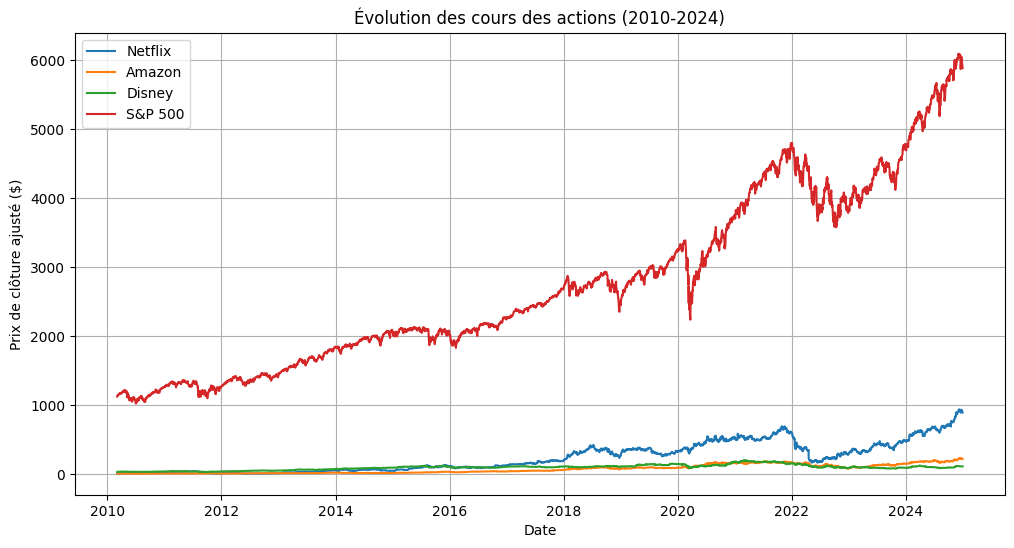

In [ ]:
# Tracé des cours des actions
plt.figure(figsize=(12, 6))
for stock in stock_data.columns:
    plt.plot(stock_data.index, stock_data[stock], label=stock)
plt.legend()
plt.title("Évolution des cours des actions (2010-2024)")
plt.xlabel("Date")
plt.ylabel("Prix de clôture ajusté ($)")
plt.grid()
plt.show()

## Illustration des rendements journaliers des actions

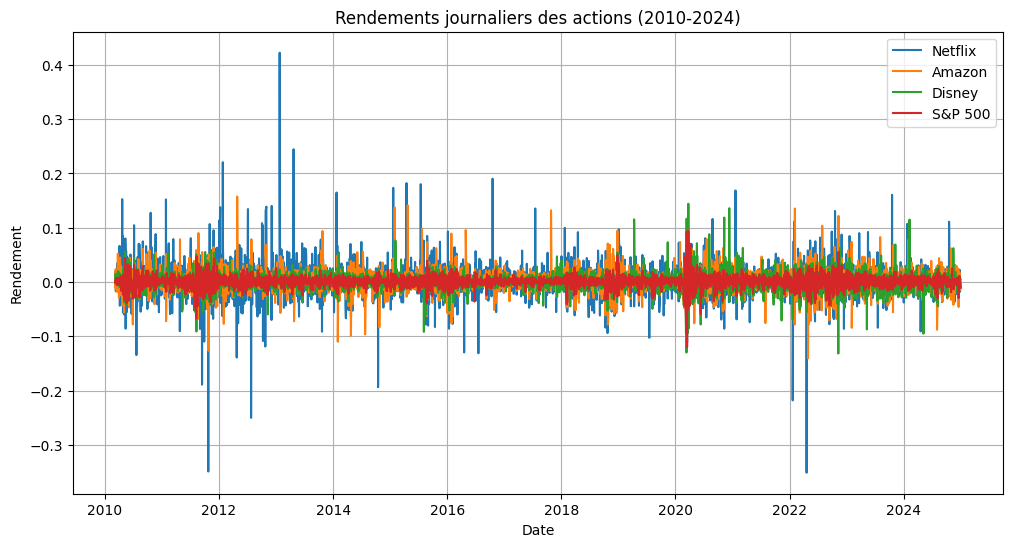

In [ ]:
# Tracé des rendements journaliers
plt.figure(figsize=(12, 6))
for stock in returns.columns:
    plt.plot(returns.index, returns[stock], label=stock)
plt.legend()
plt.title("Rendements journaliers des actions (2010-2024)")
plt.xlabel("Date")
plt.ylabel("Rendement")
plt.grid()
plt.show()

## Calcul de la volatilité

In [ ]:
# Définition du taux sans risque avec 2 % annuel
risk_free_rate = 0.02

# Calcul de la volatilité annuelle (écart-type des rendements journaliers annualisé)
volatility = returns.std() * (252 ** 0.5)  # 252 jours de bourse par an
print(volatility)

Netflix    0.497692
Amazon     0.327466
Disney     0.261515
S&P 500    0.172432
dtype: float64


## Calcul du rendement moyen annuel

In [ ]:
# Calcul du rendement moyen annuel
mean_annual_return = returns.mean() * 252
print(mean_annual_return)

Netflix    0.430321
Amazon     0.291811
Disney     0.115859
S&P 500    0.125846
dtype: float64


## Calcul du ratio de Sharpe des trois actions



In [ ]:
# Calcul du ratio de Sharpe
sharpe_ratio = (mean_annual_return - risk_free_rate) / volatility
print(sharpe_ratio)

Netflix    0.824447
Amazon     0.830044
Disney     0.366551
S&P 500    0.613842
dtype: float64


## Illustration des rendements journaliers

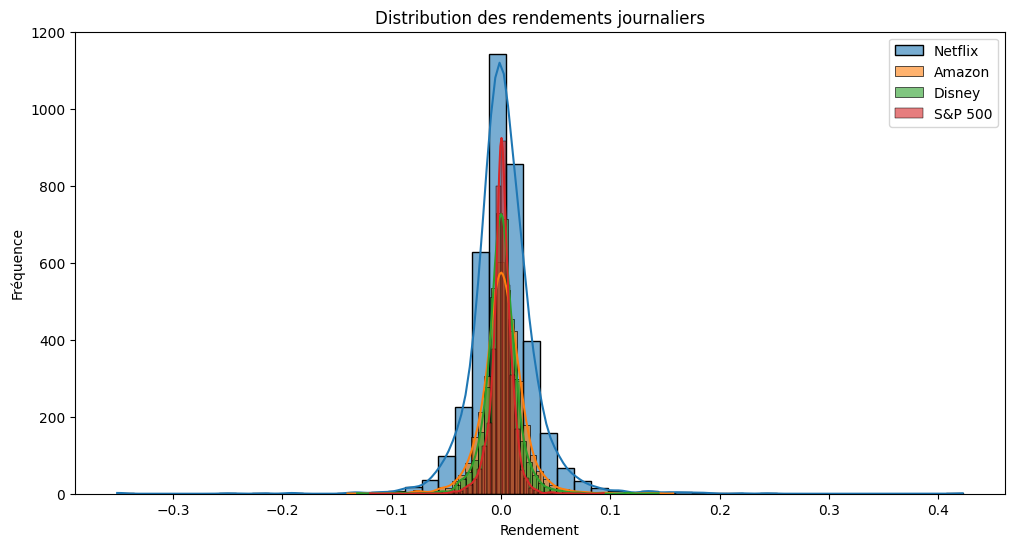

In [ ]:
# Histogramme des rendements journaliers
plt.figure(figsize=(12, 6))
for stock in returns.columns:
    sns.histplot(returns[stock], bins=50, kde=True, label=stock, alpha=0.6)
plt.legend()
plt.title("Distribution des rendements journaliers")
plt.xlabel("Rendement")
plt.ylabel("Fréquence")
plt.show()

## Illustration des rendements cumulés

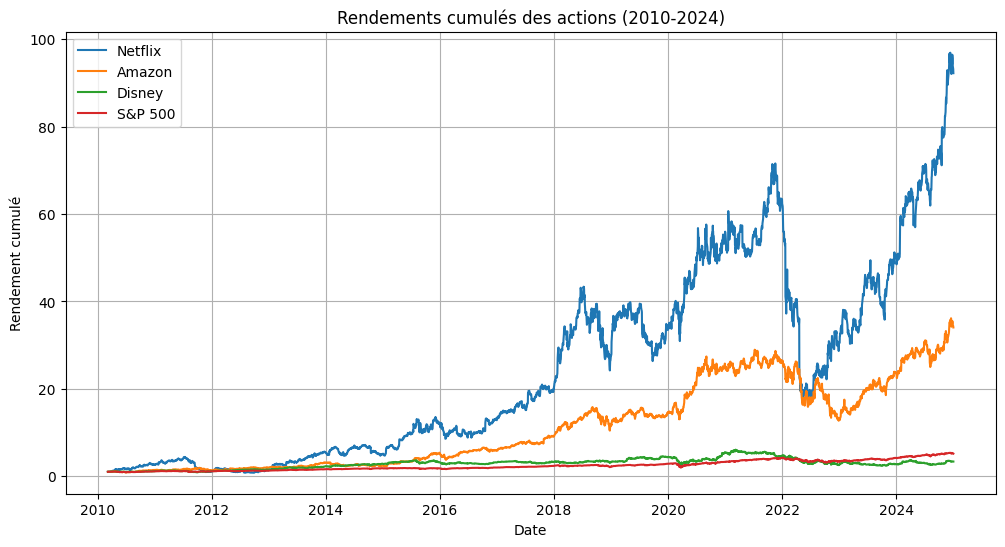

In [ ]:
# Évolution des rendements cumulés
cumulative_returns = (1 + returns).cumprod()
plt.figure(figsize=(12, 6))
for stock in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[stock], label=stock)
plt.legend()
plt.title("Rendements cumulés des actions (2010-2024)")
plt.xlabel("Date")
plt.ylabel("Rendement cumulé")
plt.grid()
plt.show()

## Illustration des distribution des rendements journaliers

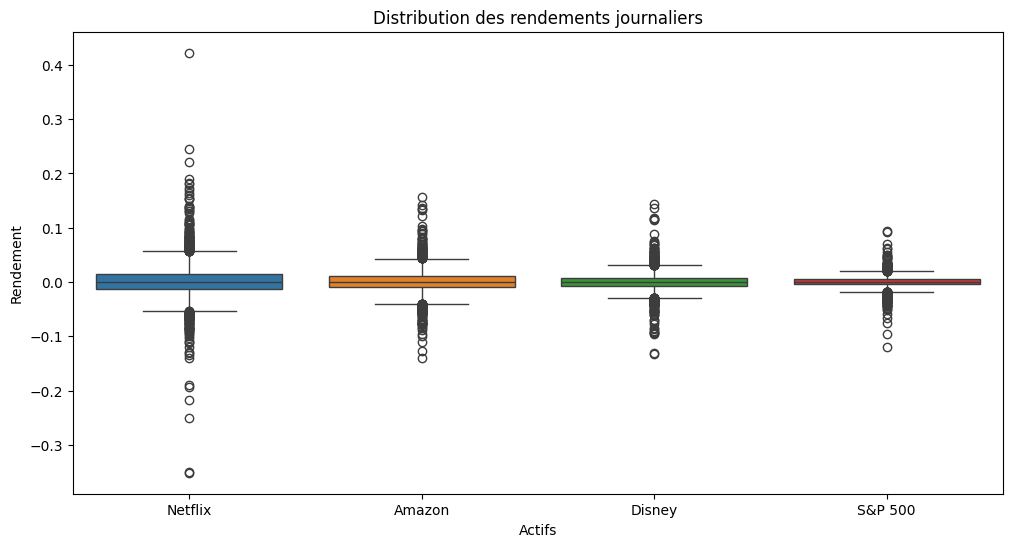

In [ ]:
# Boîte à moustaches des rendements journaliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=returns)
plt.title("Distribution des rendements journaliers")
plt.xlabel("Actifs")
plt.ylabel("Rendement")
plt.show()

## Illustration des volailités annuelle

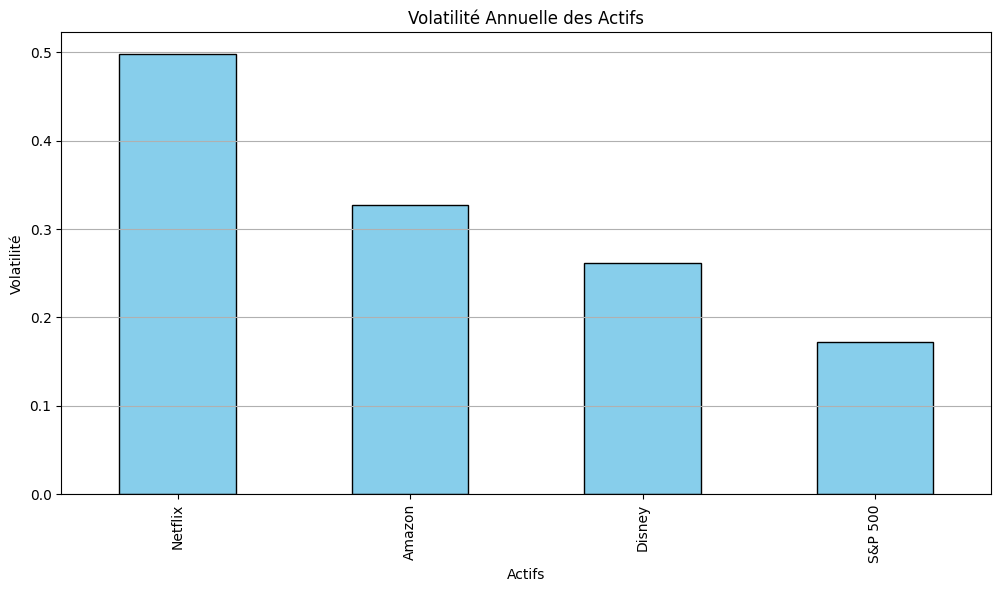

In [ ]:
# Comparaison des volatilités
plt.figure(figsize=(12, 6))
volatility.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Volatilité Annuelle des Actifs")
plt.ylabel("Volatilité")
plt.xlabel("Actifs")
plt.grid(axis='y')
plt.show()

## Illustration du ratio de Sharpe des actions

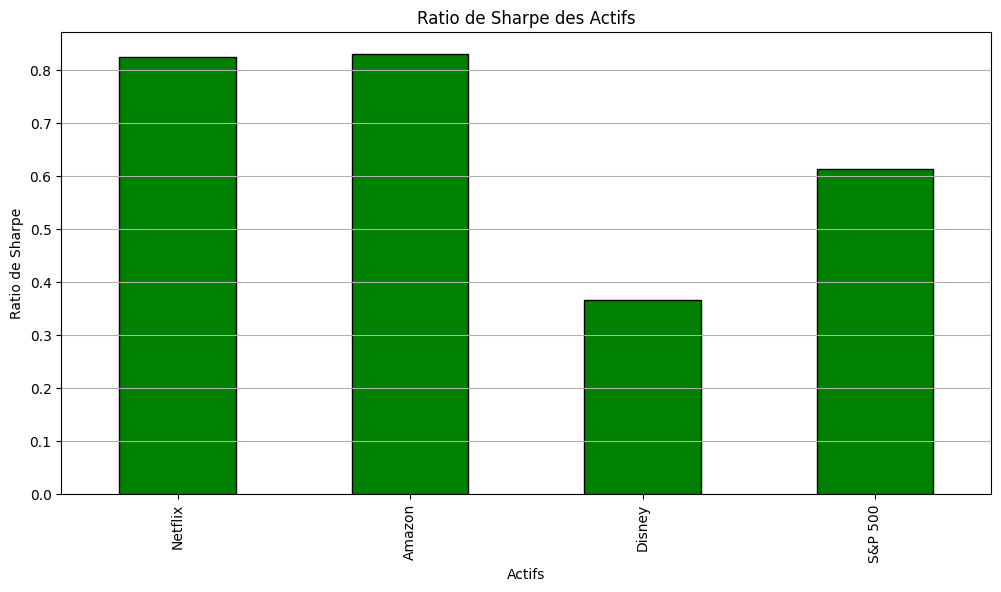

In [ ]:
# Ratio de Sharpe
plt.figure(figsize=(12, 6))
sharpe_ratio.plot(kind='bar', color='green', edgecolor='black')
plt.title("Ratio de Sharpe des Actifs")
plt.ylabel("Ratio de Sharpe")
plt.xlabel("Actifs")
plt.grid(axis='y')
plt.show()

## Illustration du heatmap des corrélations entre les rendements des différentes actions et l'indice de référence

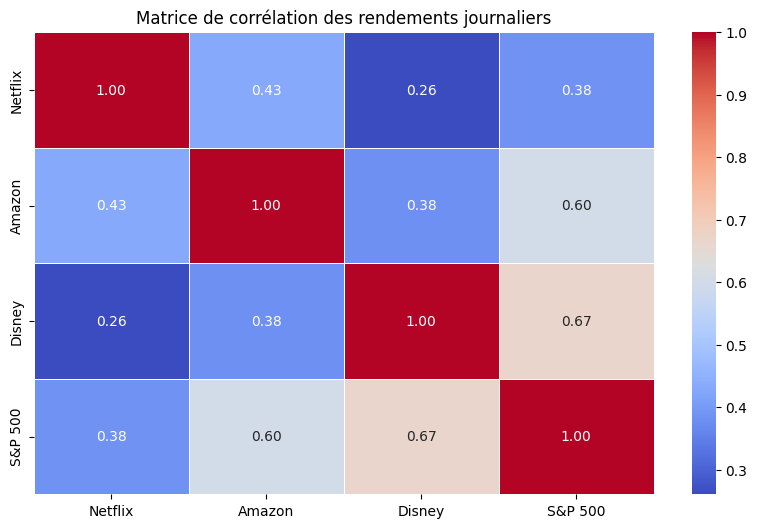

In [ ]:
# Générer la heatmap des corrélations entre les rendements
plt.figure(figsize=(10, 6))
correlation_matrix = returns.corr()  # Calculer la matrice de corrélation

# Tracer la heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Matrice de corrélation des rendements journaliers")
plt.show()

## Illustration de la distribution de la Valeur nette des actifs

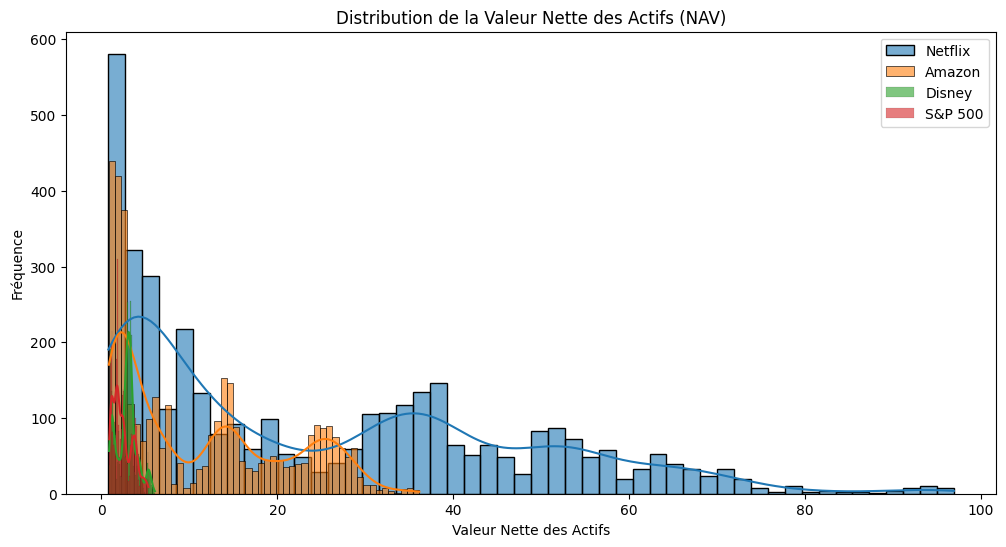

In [ ]:
# Approximation du Net Asset Value (NAV) en supposant un investissement initial de 1 USD
nav = (1 + returns).cumprod()

# Tracer la distribution du NAV
plt.figure(figsize=(12, 6))
for stock in nav.columns:
    sns.histplot(nav[stock], bins=50, kde=True, label=stock, alpha=0.6)
plt.legend()
plt.title("Distribution de la Valeur Nette des Actifs (NAV)")
plt.xlabel("Valeur Nette des Actifs")
plt.ylabel("Fréquence")
plt.show()

## Statistiques descriptives

In [ ]:
# Recalcul des statistiques descriptives
summary_statistics = returns.describe().T

# Ajout des mesures supplémentaires
summary_statistics["Skewness"] = returns.skew()
summary_statistics["Kurtosis"] = returns.kurtosis()
print(summary_statistics)

          count      mean       std       min       25%       50%       75%  \
Netflix  3731.0  0.001708  0.031352 -0.351166 -0.012303  0.000448  0.015226   
Amazon   3731.0  0.001158  0.020628 -0.140494 -0.008994  0.000955  0.011906   
Disney   3731.0  0.000460  0.016474 -0.131632 -0.006818  0.000423  0.008205   
S&P 500  3731.0  0.000499  0.010862 -0.119840 -0.003801  0.000668  0.005690   

              max  Skewness   Kurtosis  
Netflix  0.422235  0.280384  23.953121  
Amazon   0.157457  0.262552   6.288829  
Disney   0.144123  0.209346  10.511510  
S&P 500  0.093830 -0.488430  12.366057  


## Calcul du beta des actions et de l'indice de référence (S&P 500)

In [ ]:
# Beta de marché (CAPM)
market_var = returns['S&P 500'].var()
betas = returns.cov().loc[:, 'S&P 500'] / market_var
print(betas)

Netflix    1.110239
Amazon     1.140771
Disney     1.009245
S&P 500    1.000000
Name: S&P 500, dtype: float64


## Calcul de l'alpha de Jensen

In [ ]:
# Jensen’s Alpha
expected_market_return = returns['S&P 500'].mean()
jensens_alpha = returns.mean() - (risk_free_rate + betas * (expected_market_return - risk_free_rate))
print(jensens_alpha)

Netflix    3.357964e-03
Amazon     3.403717e-03
Disney     1.406432e-04
S&P 500    1.344411e-17
dtype: float64
